# This notebook is slow to run
## this is because the top level function can't be decorated for reproducibility: tf.random.set_seed doesn't do anything when inside a graph.

In [26]:
import gc
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import pykalman
import seaborn

import tensorflow as tf
import tensorflow_probability as tfp
import tqdm

# tf.function = lambda x: x
tfd = tfp.distributions

seaborn.set()
tf.random.set_seed(66)
np.random.seed(42)

In [2]:
tf.config.set_visible_devices([], 'GPU') 

In [3]:
from filterflow.smc import SMC
from filterflow.base import State, StateSeries

from filterflow.observation.linear import LinearObservationSampler

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform, PartiallyCorrectedRegularizedTransform
from filterflow.resampling.differentiable.sliced import SVDSlicedTransform
from filterflow.resampling.differentiable.optimized import OptimizedPointCloud
from filterflow.resampling.differentiable.optimizer.sgd import SGD
from filterflow.resampling.differentiable.ricatti.solver import PetkovSolver
from filterflow.resampling.differentiable.loss.sliced_wasserstein.swd import SlicedWassersteinDistance
from filterflow.resampling.differentiable.loss.regularized import SinkhornLoss
from filterflow.resampling.differentiable.loss.sliced_wasserstein.utils import sqeuclidean, norm_1

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

## Set the State Space Model

In [4]:

observation_dim = 2
state_dim = 2
T = 150
initial_state          = tf.random.uniform([state_dim], -1., 1.)

transition_matrix      = tf.eye(state_dim) * 0.5
transition_covariance  = tf.eye(state_dim) * 0.5

chol_transition_covariance = tf.linalg.cholesky(transition_covariance)

observation_matrix     = tf.eye(observation_dim)
observation_covariance = tf.eye(observation_dim) * 0.1

chol_observation_covariance = tf.linalg.cholesky(observation_covariance)

In [5]:
# Transition
zeros = tf.zeros(state_dim, dtype=float)

transition_noise = tfd.MultivariateNormalTriL(zeros, chol_transition_covariance)
transition_model = RandomWalkModel(transition_matrix, transition_noise)

# Observation
observation_error = tfp.distributions.MultivariateNormalTriL(zeros, chol_observation_covariance)
observation_model = LinearObservationSampler(observation_matrix, observation_error)

In [6]:
kf = pykalman.KalmanFilter(transition_matrix.numpy(), 
                           observation_matrix.numpy(), 
                           transition_covariance.numpy(), 
                           observation_covariance.numpy())

In [7]:
states, obs = kf.sample(T, initial_state.numpy())

In [8]:
np_obs = np.asanyarray(obs.data, dtype=np.float32)
np_states = np.asanyarray(states.data, dtype=np.float32)


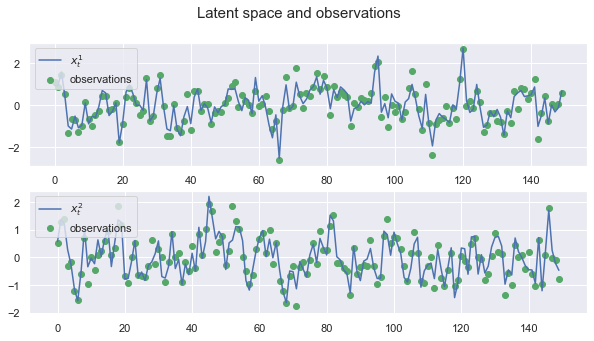

In [9]:
linspace  = np.arange(np_obs[:,0].shape[0])
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, np_obs[:,0], marker='o', color='g', label='observations')
axes[0].plot(np_states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(np_states[:, 1], color='b', label='$x^2_t$')
axes[1].scatter(linspace, np_obs[:,1], marker='o', color='g', label='observations')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [10]:
obs_data = tf.data.Dataset.from_tensor_slices(np_obs)

### Set up the filter

In [11]:
# store observations
batch_size = 50
n_particles = 25
dimension = 2

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights = tf.math.log(initial_weights),
                      weights=initial_weights, 
                      log_likelihoods=log_likelihoods, 
                      ancestor_indices=None, 
                      resampling_correction=None)


modifiable_transition_matrix = tf.Variable(tf.linalg.diag([0., 0.]))
modifiable_transition_model = RandomWalkModel(modifiable_transition_matrix, transition_noise)
modifiable_proposal_model = BootstrapProposalModel(modifiable_transition_model)


In [12]:
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
multinomial = MultinomialResampler()

epsilon = tf.constant(0.5)
scaling = tf.constant(0.75)
convergence_threshold=tf.constant(1e-2)
max_iter=tf.constant(500)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=max_iter, convergence_threshold=convergence_threshold)


solver = PetkovSolver(tf.constant(50))

corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=max_iter, convergence_threshold=convergence_threshold, ricatti_solver=solver, propagate_correction_gradient=tf.constant(False))
propagated_corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=max_iter, convergence_threshold=convergence_threshold, ricatti_solver=solver, propagate_correction_gradient=tf.constant(True))
partially_corrected = PartiallyCorrectedRegularizedTransform(regularized)

learning_rate, n_epochs, decay = tf.constant(0.1), tf.constant(50), tf.constant(0.95)

sinkhorn_loss = SinkhornLoss(epsilon, symmetric=True, scaling=scaling, max_iter=max_iter, convergence_threshold=convergence_threshold)
sinkhorn_optimizer = SGD(sinkhorn_loss, learning_rate, n_epochs, decay)
sinkhorn_optimized_cloud = OptimizedPointCloud(sinkhorn_optimizer, regularized)

svd_sliced_resampler = SVDSlicedTransform(1)
partially_corrected_svd = PartiallyCorrectedRegularizedTransform(svd_sliced_resampler)


sliced_loss = SlicedWassersteinDistance(tf.constant(10), norm_1)
sliced_optimizer = SGD(sliced_loss, learning_rate, n_epochs, decay)
sliced_optimized_cloud = OptimizedPointCloud(sliced_optimizer, regularized)

multinomial_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, multinomial)
regularized_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, regularized)
corrected_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, corrected)
propagated_corrected_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, propagated_corrected)
partially_corrected_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, partially_corrected)
sinkhorn_optimized_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, sinkhorn_optimized_cloud)
sliced_optimized_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, sliced_optimized_cloud)
svd_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, svd_sliced_resampler)
partially_corrected_svd_smc = SMC(observation_model, modifiable_transition_model, modifiable_proposal_model, resampling_criterion, partially_corrected_svd)




In [13]:
mesh_size = 3
x_linspace = np.linspace(0.25, 0.75, mesh_size).astype(np.float32)
y_linspace = np.linspace(0.25, 0.75, mesh_size).astype(np.float32)
np_mesh = np.asanyarray([(x, y) for x in x_linspace for y in y_linspace]).astype(np.float32)
mesh = tf.data.Dataset.from_tensor_slices(np_mesh)

In [14]:
@tf.function
def get_res(smc, use_correction_term):
    with tf.GradientTape() as tape:
        tape.watch(modifiable_transition_matrix)
        final_state = smc(initial_state, observation_series=obs_data, n_observations=T, return_final=True)
        ll = final_state.log_likelihoods
        if use_correction_term:
            correction_term = final_state.resampling_correction
            corrected_ll = ll + correction_term
        else:
            corrected_ll = ll
    ll_grad = tape.jacobian(corrected_ll, modifiable_transition_matrix, experimental_use_pfor=False)
    return ll, tf.linalg.diag_part(ll_grad)

In [15]:
@tf.function
def get_surface(mesh_dataset, smc, use_correction_term):
    ll_array = tf.TensorArray(size=mesh_size**2, dtype=tf.float32, dynamic_size=False)
    grad_array = tf.TensorArray(size=mesh_size**2, dtype=tf.float32, dynamic_size=False)
    for i, tf_val in mesh_dataset.enumerate():
        transition_matrix = tf.linalg.diag(tf_val)
        assign_op = modifiable_transition_matrix.assign(transition_matrix)
        with tf.control_dependencies([assign_op]):
            ll, ll_grad = get_res(smc, use_correction_term)
        ll_array = ll_array.write(tf.cast(i, tf.int32), ll)
        grad_array = grad_array.write(tf.cast(i, tf.int32), ll_grad)
        tf.print('i', i+1, end='\r')
    return ll_array.stack(), grad_array.stack()
        

In [16]:
min_, max_ = -480, -375

In [17]:
kf_res = []
kf_res_grad = []
eps = 1e-5

for val in tqdm.tqdm(mesh):
    a_val, b_val = val
    transition_matrix_np_a_eps = np.diag([a_val+eps, b_val])
    transition_matrix_np_b_eps = np.diag([a_val, b_val+eps])
    transition_matrix_np = np.diag([a_val, b_val])
    
    kf_a_eps = pykalman.KalmanFilter(transition_matrix_np_a_eps, 
                                     observation_matrix.numpy(), 
                                     transition_covariance.numpy(), 
                                     observation_covariance.numpy(), 
                                     initial_state_mean=[0., 0.], 
                                     initial_state_covariance=np.eye(2))
    
    kf_b_eps = pykalman.KalmanFilter(transition_matrix_np_b_eps, 
                                     observation_matrix.numpy(), 
                                     transition_covariance.numpy(), 
                                     observation_covariance.numpy(), 
                                     initial_state_mean=[0., 0.], 
                                     initial_state_covariance=np.eye(2))
    
    kf = pykalman.KalmanFilter(transition_matrix_np, 
                               observation_matrix.numpy(), 
                               transition_covariance.numpy(), 
                               observation_covariance.numpy(), 
                               initial_state_mean=[0., 0.], 
                               initial_state_covariance=np.eye(2))
    
    ll = kf.loglikelihood(np_obs)
    ll_a_eps = kf_a_eps.loglikelihood(np_obs)
    ll_b_eps = kf_b_eps.loglikelihood(np_obs)
    
    kf_res.append(ll)
    kf_res_grad.append([(ll_a_eps-ll)/eps, (ll_b_eps-ll)/eps])
kf_res = np.asanyarray(kf_res)
kf_res_grad = np.asanyarray(kf_res_grad)

9it [00:02,  4.33it/s]


In [18]:
regularized_data, regularized_grad = get_surface(mesh, regularized_smc, False)
regularized_data = regularized_data.numpy()
regularized_grad = regularized_grad.numpy()

In [19]:
partially_corrected_data, partially_corrected_grad = get_surface(mesh, partially_corrected_smc, False)
partially_corrected_data = partially_corrected_data.numpy()
partially_corrected_grad = partially_corrected_grad.numpy()

In [20]:
corrected_multinomial_data, corrected_multinomial_grad = get_surface(mesh, multinomial_smc, True)
corrected_multinomial_data = corrected_multinomial_data.numpy()
corrected_multinomial_grad = corrected_multinomial_grad.numpy()

In [21]:
multinomial_data, multinomial_grad = get_surface(mesh, multinomial_smc, False)
multinomial_data = multinomial_data.numpy()
multinomial_grad = multinomial_grad.numpy()

In [22]:
svd_data, svd_grad = get_surface(mesh, svd_smc, False)
svd_data = svd_data.numpy()
svd_grad = svd_grad.numpy()

In [23]:
partially_corrected_svd_data, partially_corrected_svd_grad = get_surface(mesh, partially_corrected_svd_smc, False)
partially_corrected_svd_data = partially_corrected_svd_data.numpy()
partially_corrected_svd_grad = partially_corrected_svd_grad.numpy()

In [24]:
sinkhorn_optimized_data, sinkhorn_optimized_grad = get_surface(mesh, sinkhorn_optimized_smc, False)
sinkhorn_optimized_data = sinkhorn_optimized_data.numpy()
sinkhorn_optimized_grad = sinkhorn_optimized_grad.numpy()

ResourceExhaustedError:     [_Derived_]  OOM when allocating tensor with shape[50,25,25] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node while_253/body/_1/PartitionedCall/PartitionedCall_5/gradients/PartitionedCall_5_grad/PartitionedCall/gradients/truediv_7_grad/RealDiv_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/while_465/body/_4391/StatefulPartitionedCall/PartitionedCall_4]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[StatefulPartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[ReduceDataset]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_get_surface_61596]

Function call stack:
get_surface -> tf_data_experimental_scan_scan_body -> get_res -> get_res -> __call__ -> __call__


In [ ]:
sliced_optimized_data, sliced_optimized_grad = get_surface(mesh, sliced_optimized_smc, False)
sliced_optimized_data = sliced_optimized_data.numpy()
sliced_optimized_grad = sliced_optimized_grad.numpy()

In [24]:
x_linspace

array([0.25, 0.5 , 0.75], dtype=float32)

In [27]:
multinomial_ll_df = pd.DataFrame({'mean': multinomial_data.mean(1), 'std': multinomial_data.std(1), '$\phi_1$': np_mesh[:, 0], '$\phi_2$': np_mesh[:, 1]}).set_index(['$\phi_1$', '$\phi_2$'])
regularized_ll_df = pd.DataFrame({'mean': regularized_data.mean(1), 'std': regularized_data.std(1), '$\phi_1$': np_mesh[:, 0], '$\phi_2$': np_mesh[:, 1]}).set_index(['$\phi_1$', '$\phi_2$'])
partially_corrected_ll_df = pd.DataFrame({'mean': partially_corrected_data.mean(1), 'std': partially_corrected_data.std(1), '$\phi_1$': np_mesh[:, 0], '$\phi_2$': np_mesh[:, 1]}).set_index(['$\phi_1$', '$\phi_2$'])

In [28]:
def get_grad_df(grad_data):
    df = pd.DataFrame({'mean($\phi_1$)': grad_data.mean(1)[:, 0], 'mean($\phi_2$)': grad_data.mean(1)[:, 1], 'std($\phi_1$)': grad_data.std(1)[:, 0], 'std($\phi_2$)': grad_data.std(1)[:, 1], '$\phi_1$': np_mesh[:, 0], '$\phi_2$': np_mesh[:, 1]})
    return df.set_index(['$\phi_1$', '$\phi_2$'])


In [29]:
pd.MultiIndex.from_tuples(np_mesh.tolist())

MultiIndex(levels=[[0.25, 0.5, 0.75], [0.25, 0.5, 0.75]],
           codes=[[0, 0, 0, 1, 1, 1, 2, 2, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2]])

In [30]:
kf_ll_df = pd.DataFrame(kf_res, columns=[''], index=pd.MultiIndex.from_tuples(np_mesh.tolist()))

In [31]:
kf_grad_df = pd.DataFrame(kf_res_grad, columns=['mean($\phi_1$)', 'mean($\phi_2$)'], index=pd.MultiIndex.from_tuples(np_mesh.tolist()))

In [32]:
multinomial_grad_df = get_grad_df(multinomial_grad)
regularized_grad_df = get_grad_df(regularized_grad)
partially_corrected_grad_df = get_grad_df(partially_corrected_grad)

In [37]:
grad_df = pd.concat([kf_grad_df, multinomial_grad_df, regularized_grad_df, partially_corrected_grad_df], axis=1, keys=['Kalman', 'Multinomial', 'Regularized', 'Partially Corrected'])
grad_df.index.names = ['$\phi_1$', '$\phi_2$']
print(grad_df.sort_index(axis=1).to_latex(float_format="%.3f"))

\begin{tabular}{llrrrrrrrrrrrrrr}
\toprule
     &      & \multicolumn{2}{l}{Kalman} & \multicolumn{4}{l}{Multinomial} & \multicolumn{4}{l}{Partially Corrected} & \multicolumn{4}{l}{Regularized} \\
     &      & mean(\$\textbackslash phi\_1\$) & mean(\$\textbackslash phi\_2\$) & mean(\$\textbackslash phi\_1\$) & mean(\$\textbackslash phi\_2\$) & std(\$\textbackslash phi\_1\$) & std(\$\textbackslash phi\_2\$) &      mean(\$\textbackslash phi\_1\$) & mean(\$\textbackslash phi\_2\$) & std(\$\textbackslash phi\_1\$) & std(\$\textbackslash phi\_2\$) & mean(\$\textbackslash phi\_1\$) & mean(\$\textbackslash phi\_2\$) & std(\$\textbackslash phi\_1\$) & std(\$\textbackslash phi\_2\$) \\
\midrule
0.25 & 0.25 &         18.412 &         19.442 &         33.170 &         34.276 &        16.057 &        17.102 &              33.477 &         32.979 &        16.440 &        18.150 &         33.428 &         33.206 &        15.293 &        17.208 \\
     & 0.50 &         18.412 &         -9.642 &     

In [38]:
grad_df.sort_index(axis=1)

Kalman                   Multinomial                 \
          mean($\phi_1$) mean($\phi_2$) mean($\phi_1$) mean($\phi_2$)   
0.25 0.25      18.411773      19.441830      33.169548      34.275902   
     0.50      18.411773      -9.641771      42.628910      -8.480677   
     0.75      18.411773     -40.121547      48.504032     -93.942528   
0.50 0.25     -16.587879      19.441830     -24.702019      36.303497   
     0.50     -16.587879      -9.641771     -19.378550     -10.488451   
     0.75     -16.587879     -40.121547     -25.791094     -90.444199   
0.75 0.25     -52.726193      19.441830    -153.635925      40.863476   
     0.50     -52.726193      -9.641771    -155.255630      -8.073200   
     0.75     -52.726193     -40.121547    -153.411011     -74.641541   

                                      Partially Corrected                 \
          std($\phi_1$) std($\phi_2$)      mean($\phi_1$) mean($\phi_2$)   
0.25 0.25     16.057442     17.102005           33.477013      32.979237   
     0.50     19.369308     23.055603           38.358345      -9.136387   
     0.75     20.537525     44.750542           45.283924     -91.870758   
0.50 0.25     28.085503     14.126840          -19.205704      33.685059   
     0.50     26.640011     21.399029          -23.398865     -10.039026   
     0.75     29.363459     43.414204          -28.063862     -89.033600   
0.75 0.25     49.795666     20.108599         -161.694870      39.948425   
     0.50     53.728794     19.273167         -161.536606      -5.897997   
     0.75     55.766541     38.550510         -158.412994     -84.656067   

                                         Regularized                 \
          std($\phi_1$) std($\phi_2$) mean($\phi_1$) mean($\phi_2$)   
0.25 0.25     16.439720     18.149975      33.427696      33.205997   
     0.50     19.031675     18.740765      39.106880      -8.061780   
     0.75     18.914034     47.668961      46.378960     -76.663651   
0.50 0.25     25.768545     16.583290     -15.063661      32.926136   
     0.50     29.753712     20.778856     -19.397375      -7.117575   
     0.75     33.130726     55.184040     -19.965008     -69.297852   
0.75 0.25     61.242493     21.941771    -118.848465      39.025768   
     0.50     52.635117     27.671124    -117.457275      -4.985628   
     0.75     66.887772     49.067207    -118.695236     -62.647041   

                                       
          std($\phi_1$) std($\phi_2$)  
0.25 0.25     15.292824     17.208115  
     0.50     17.400494     15.551160  
     0.75     17.937185     28.800291  
0.50 0.25     21.526079     15.510586  
     0.50     26.012306     17.940357  
     0.75     29.243759     37.538189  
0.75 0.25     42.493816     19.692314  
     0.50     39.140495     20.189320  
     0.75     43.213650     30.973587

In [39]:
ll_df = pd.concat([kf_ll_df, multinomial_ll_df, regularized_ll_df, partially_corrected_ll_df], axis=1, keys=['Kalman', 'Multinomial', 'Regularized', 'Partially Corrected'])
print(ll_df.sort_index(axis=1).to_latex(float_format="%.3f"))

\begin{tabular}{llrrrrrrr}
\toprule
     &      &   Kalman & \multicolumn{2}{l}{Multinomial} & \multicolumn{2}{l}{Partially Corrected} & \multicolumn{2}{l}{Regularized} \\
     &      &        mean &    std &                mean &    std &        mean &    std \\
\midrule
0.25 & 0.25 & -345.641 &    -396.520 & 14.698 &            -396.323 & 14.099 &    -396.361 & 14.110 \\
     & 0.50 & -344.365 &    -395.271 & 13.623 &            -395.210 & 13.689 &    -395.494 & 13.886 \\
     & 0.75 & -350.573 &    -406.359 & 12.980 &            -406.362 & 13.647 &    -406.279 & 13.338 \\
0.50 & 0.25 & -345.362 &    -394.598 & 12.207 &            -394.901 & 12.245 &    -395.070 & 12.567 \\
     & 0.50 & -344.087 &    -391.241 & 15.585 &            -392.308 & 15.801 &    -392.347 & 15.745 \\
     & 0.75 & -350.295 &    -399.620 & 10.337 &            -397.226 & 11.432 &    -397.078 & 11.663 \\
0.75 & 0.25 & -354.020 &    -406.576 & 13.339 &            -406.374 & 13.243 &    -406.685 & 13.390 \\
     &